# Explorative Analysis of the Younger Dataset

In [1]:
import os
import pathlib
import networkx as nx
from tqdm import tqdm
import pickle as pkl
import json

import onnx
from onnx.shape_inference import infer_shapes

import matplotlib.pyplot as plt

from youngernns.data.network import Network
from youngernns.utils.nn_translation import networkx_to_onnx

from collections import Counter

import tensorflow as tf
import numpy as np

2024-11-08 20:23:47.979927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 20:23:48.052285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 20:23:48.071905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 20:23:48.175690: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 20:23:49.619384: W tensorflow/compiler/tf2

## Global Variables

In [2]:
DATA_PATH = os.path.join("..","data","filter_series_with_attributes_paper")
OUTPUT_DIR = os.path.join("..", "output")

## Loading Data

In [3]:
def get_graph_paths():
    # find all paths for network folders DATA_PATH/gaphd_id/network/
    graph_folders = []
    for root, dirs, files in os.walk(DATA_PATH):
        if 'network' in dirs:
            graph_folders.append(os.path.join(root, 'network'))
    return graph_folders

In [4]:
graph_paths = get_graph_paths()
print(f"Found {len(graph_paths)} graphs")
print(f"Example of first graph path: {graph_paths[0]}")

Found 7629 graphs
Example of first graph path: ../data/filter_series_with_attributes_paper/0ad2b9b313487b294428174cf56d7d22/network


Let's look at the first graph

In [5]:
NN = Network()
NN.load(pathlib.Path(graph_paths[0]))

In [6]:
NN.graph.nodes(data=True)["0"]

{'operator': {'op_type': 'Transpose', 'domain': ''},
 'attributes': {'perm': {'value': [0, 3, 1, 2],
   'doc_string': '',
   'attr_type': 7}},
 'features': {'operator': {'op_type': 'Transpose', 'domain': ''},
  'attributes': {'perm': (7, '[0, 3, 1, 2]')}}}

In [7]:
NN.graph.nodes(data=True)

NodeDataView({'0': {'operator': {'op_type': 'Transpose', 'domain': ''}, 'attributes': {'perm': {'value': [0, 3, 1, 2], 'doc_string': '', 'attr_type': 7}}, 'features': {'operator': {'op_type': 'Transpose', 'domain': ''}, 'attributes': {'perm': (7, '[0, 3, 1, 2]')}}}, '1': {'operator': {'op_type': 'Conv', 'domain': ''}, 'attributes': {'dilations': {'value': [1, 1], 'doc_string': '', 'attr_type': 7}, 'strides': {'value': [1, 1], 'doc_string': '', 'attr_type': 7}, 'kernel_shape': {'value': [3, 3], 'doc_string': '', 'attr_type': 7}, 'group': {'value': 1, 'doc_string': '', 'attr_type': 2}}, 'features': {'operator': {'op_type': 'Conv', 'domain': ''}, 'attributes': {'auto_pad': (3, "b'NOTSET'"), 'dilations': (7, '[1, 1]'), 'group': (2, '1'), 'kernel_shape': (7, '[3, 3]'), 'pads': (7, 'None'), 'strides': (7, '[1, 1]')}}}, '2': {'operator': {'op_type': 'Relu', 'domain': ''}, 'attributes': {}, 'features': {'operator': {'op_type': 'Relu', 'domain': ''}, 'attributes': {}}}, '3': {'operator': {'op_t

Let's look at the graph operators

In [8]:
def get_graph_operator_types(graph):
    for att in nx.get_node_attributes(graph, "operator").values():
        yield att['op_type'] 

In [9]:
operators_pickle_path = os.path.join(OUTPUT_DIR, "operator_types.pkl")

if not os.path.exists(operators_pickle_path):
    operator_types = []

    for graph_path in tqdm(graph_paths):
        NN = Network()
        NN.load(pathlib.Path(graph_path))
        operator_types.extend(get_graph_operator_types(NN.graph))

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    with open(operators_pickle_path, "wb") as f:
        pkl.dump(operator_types, f)
    
    print(f"Saved {len(operator_types)} operator types")
    print(f"Saved to {operators_pickle_path}")
else:
    with open(operators_pickle_path, "rb") as f:
        operator_types = pkl.load(f)
        print(f"Loaded {len(operator_types)} operator types")

Loaded 12396579 operator types


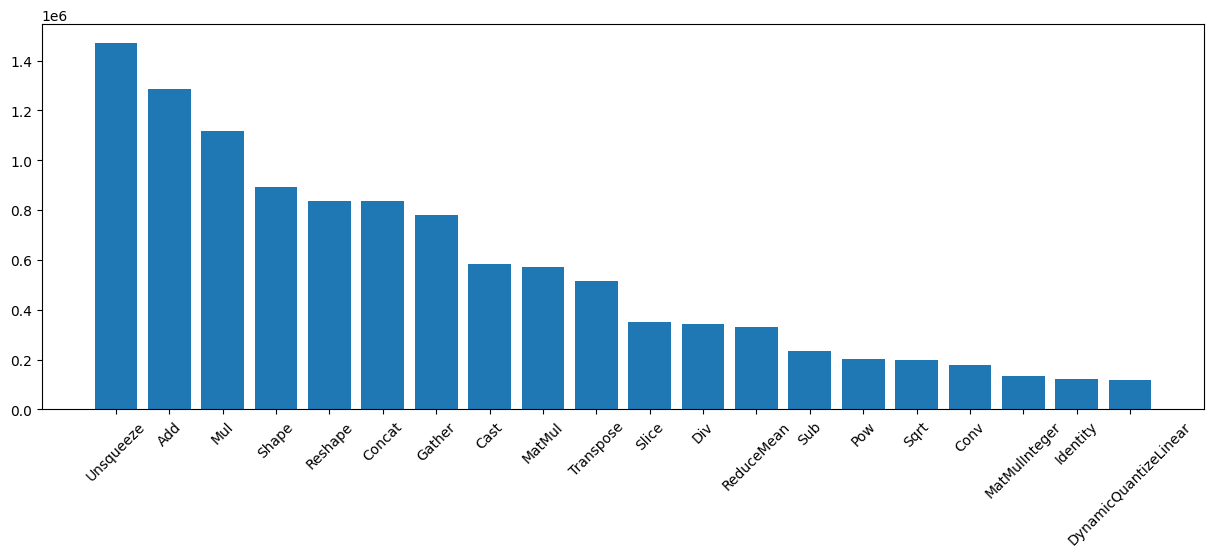

In [10]:
# plot histogram of top X operator types
operator_types_counter = Counter(operator_types)
top_x = 20
top_x_operator_types = operator_types_counter.most_common(top_x)

plt.figure(figsize=(15,5))
plt.bar([x[0] for x in top_x_operator_types], [x[1] for x in top_x_operator_types])
plt.xticks(rotation=45)
plt.show()

Let's look at the edges

In [11]:

for u, v, data in NN.graph.edges(data=True):
    print(f"Edge ({u}, {v}) has attributes {data}")

Edge (0, 1) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (1, 2) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (2, 3) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (3, 4) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (4, 5) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (5, 6) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (6, 7) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (7, 8) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (8, 9) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (9, 10) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (10, 11) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (11, 12) has attributes {'connection': {'emit_index': 0, 'trap_index': 0}}
Edge (12, 13) has attributes {'connection': {'emit_index': 

# Check for Graphs with No Nodes

In [12]:
empty_graph_idxs = []

# Find graphs with no nodes
for i, graph_path in tqdm(enumerate(graph_paths), total=len(graph_paths)):
    NN = Network()
    NN.load(pathlib.Path(graph_path))
    if len(NN.graph.nodes) == 0:
        empty_graph_idxs.append(i)

print(f"Found {len(empty_graph_idxs)} empty graph(s)")

100%|██████████| 7629/7629 [01:54<00:00, 66.91it/s] 

Found 1 empty graph(s)


In [13]:
print(empty_graph_idxs)

[1307]


Let's look at the empty graph

In [14]:
empty_graph = Network()
empty_graph.load(pathlib.Path(graph_paths[empty_graph_idxs[0]]))


In [15]:
empty_graph.graph.nodes(data=True)

NodeDataView({})

In [16]:
empty_graph.graph.edges(data=True)

OutEdgeDataView([])

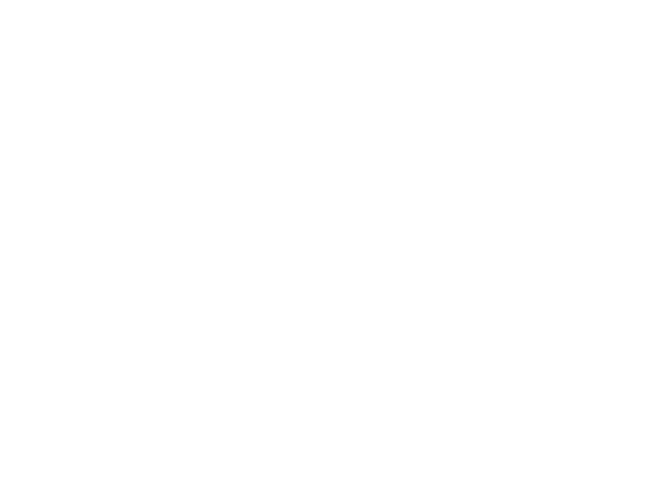

In [17]:
# plot the graph
nx.draw(empty_graph.graph, with_labels=True, font_weight='bold')

Let's remove it

In [18]:
print(f"Removing empty graph at index {empty_graph_idxs[0]}")
print(f"Number of graphs before: {len(graph_paths)}")
graph_paths.pop(empty_graph_idxs[0])
print(f"Number of graphs after: {len(graph_paths)}")

Removing empty graph at index 1307
Number of graphs before: 7629
Number of graphs after: 7628


## Check for Trees
Let's see how many of the graphs a trees.
A graph is a tree if it has a single root node and the in degree of all remaining nodes is one.
We do this because if a graph is a tree we might be able to do some things faster or use other algorithms.

In [19]:
# Save trees to tree_list and other to other_list
tree_idxs = [] 

for i, graph_path in tqdm(enumerate(graph_paths), total=len(graph_paths)):
    NN = Network()
    NN.load(pathlib.Path(graph_path))
    if nx.is_tree(NN.graph):
        tree_idxs.append(i)

print(f"Counted trees: {len(tree_idxs)}/{len(graph_paths)}")

100%|██████████| 7628/7628 [01:54<00:00, 66.78it/s] 

Counted trees: 498/7628


## Let's Analyize the Topology of the Graphs

### Depth Analysis

In [20]:
#Analyze depth of the graphs
depths = []
for graph_path in tqdm(graph_paths):
    NN = Network()
    NN.load(pathlib.Path(graph_path))
    depths.append(nx.dag_longest_path_length(NN.graph))

100%|██████████| 7628/7628 [03:19<00:00, 38.17it/s]


In [21]:
print(f"Max depth: {max(depths)}")
print(f"Min depth: {min(depths)}")

Max depth: 38414
Min depth: 0


In [22]:
# Count depths
depth_counter = Counter(depths)

# sort depths descending
depths_keys = list(depth_counter.keys())
depths_keys.sort(reverse=True)

# print top X max depths
top_x = 10
top_x_depths = depths_keys[:top_x]

for dpt in top_x_depths:
    print(f"Depth {dpt}: {depth_counter[dpt]}")

Depth 38414: 1
Depth 21961: 1
Depth 21173: 1
Depth 6854: 1
Depth 6848: 1
Depth 6840: 1
Depth 6834: 1
Depth 6396: 1
Depth 6394: 1
Depth 6392: 2


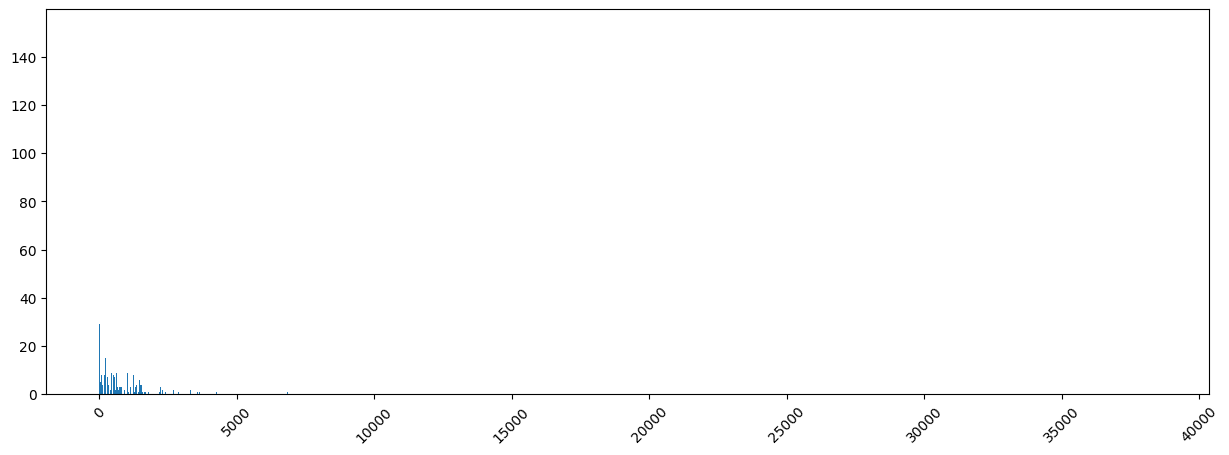

In [23]:
# Plot depth distribution
plt.figure(figsize=(15,5))
plt.bar(*zip(*sorted(depth_counter.items())))
plt.xticks(rotation=45)
plt.show()

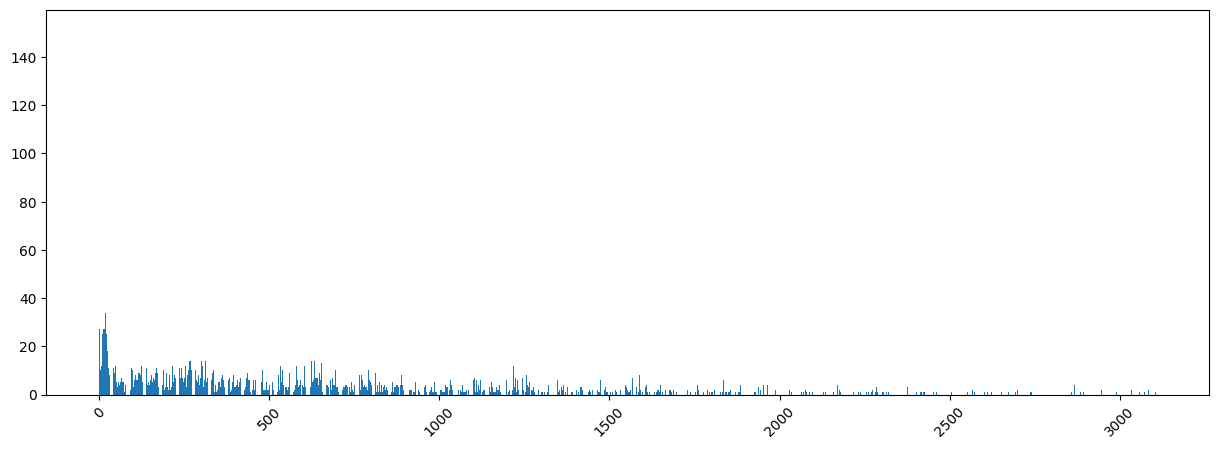

In [24]:
# Plot X first depth count distribution
X = 1750
plt.figure(figsize=(15,5))
plt.bar(*zip(*sorted(depth_counter.items())[:X]))
plt.xticks(rotation=45)
plt.show()

### Width Analysis

In [25]:
# Analyze width of the graphs
widths = []
for graph_path in tqdm(graph_paths):
    NN = Network()
    NN.load(pathlib.Path(graph_path))

    # Find the number of children for each node
    children = {node: 0 for node in NN.graph.nodes}

    for u, v, data in NN.graph.edges(data=True):
        children[v] += 1

    widths.extend(list(children.values()))

100%|██████████| 7628/7628 [02:00<00:00, 63.14it/s] 


In [26]:
# Count depths
width_counter = Counter(widths)

# sort depths descending
widths_keys = list(width_counter.keys())
widths_keys.sort(reverse=True)

# print top X max depths
top_x = 10
top_x_widths = widths_keys[:top_x]

for wdt in top_x_widths:
    print(f"Width {wdt}: {width_counter[wdt]}")

Width 5278: 5
Width 5000: 5
Width 100: 2
Width 90: 31
Width 80: 27
Width 64: 34
Width 53: 5
Width 49: 2
Width 48: 74
Width 47: 2


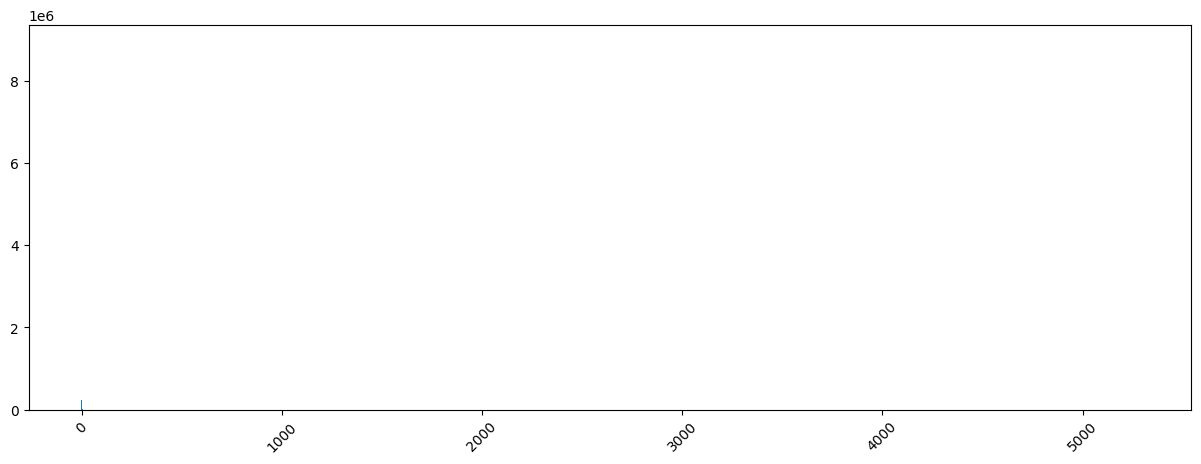

In [27]:
# Plot depth distribution
plt.figure(figsize=(15,5))
plt.bar(*zip(*sorted(width_counter.items())))
plt.xticks(rotation=45)
plt.show()

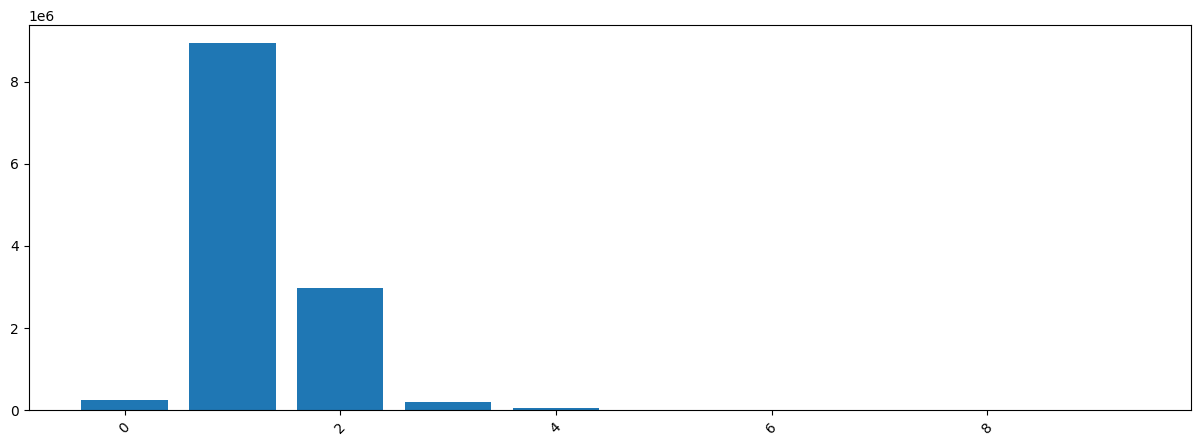

In [28]:
# Plot X first depth count distribution
X = 10
plt.figure(figsize=(15,5))
plt.bar(*zip(*sorted(width_counter.items())[:X]))
plt.xticks(rotation=45)
plt.show()

## Label info
We now look at the meta data in the label.json files associated with each of the networks.

In [29]:
def get_label_paths():
    # find all paths for network label info DATA_PATH/network-id/label.json
    label_paths = []

    for root, dirs, files in os.walk(DATA_PATH):
        if 'label.json' in files:
            label_paths.append(os.path.join(root, 'label.json'))
    
    return label_paths

In [30]:
label_paths = get_label_paths()
print(f"Found {len(label_paths)} graphs")
print(f"Example of first graph path: {label_paths[0]}")

Found 7629 graphs
Example of first graph path: ../data/filter_series_with_attributes_paper/0ad2b9b313487b294428174cf56d7d22/label.json


In [31]:
# Look at the first label data
with open(label_paths[0], "r") as f:
    label_data = json.load(f)
    print(label_data)

{'model_sources': ['HuggingFace'], 'downloads': [0, 1, 2, 4], 'likes': [0], 'tags': ['keras', 'image-classification', 'onnx', 'region:us', 'license:mit', 'mobilenet'], 'evaluations': [], 'hash': '0ad2b9b313487b294428174cf56d7d22'}


In [32]:
label_data = []

# Load label data
for label_path in tqdm(label_paths):
    with open(label_path, "r") as f:
        label_data.append(json.loads(f.read()))



100%|██████████| 7629/7629 [00:01<00:00, 4422.08it/s]


In [33]:
# Find all unique keys
all_keys = set()
for label in label_data:
    all_keys.update(label.keys())

print(f"Found {len(all_keys)} unique keys")
print(all_keys)

Found 6 unique keys
{'hash', 'evaluations', 'likes', 'model_sources', 'tags', 'downloads'}


In [34]:
# Check for graphs with empty label values
key_value_counts = {key: 0 for key in all_keys}

for key in key_value_counts.keys():
    for label in label_data:
        if label.get(key, []):
            key_value_counts[key] += 1

In [35]:
key_value_counts

{'hash': 7629,
 'evaluations': 600,
 'likes': 7446,
 'model_sources': 7629,
 'tags': 7536,
 'downloads': 7446}

So we see that not all networks have label data.

Let's look at the evaluations label

In [36]:
evaluations_label_data = []

for label in label_data:
    if label['evaluations']:
        evaluations_label_data.append(label['evaluations'])

In [37]:
evaluations_label_data[0]

[['text generation', 'humanevalfix python', 'test', 'pass @1', 3.2],
 ['text generation', 'humanevalfix javascript', 'test', 'pass @1', 4.9],
 ['text generation', 'humanevalfix java', 'test', 'pass @1', 1.8],
 ['text generation', 'humanevalfix go', 'test', 'pass @1', 3.6],
 ['text generation', 'humanevalfix', 'test', 'pass @1', 4.2],
 ['text generation', 'humanevalfix rust', 'test', 'pass @1', 1.7],
 ['text generation', 'humanevalfix', 'test', 'pass @1', 3.3],
 ['text generation', 'humaneval', 'test', 'pass @1', 39.0],
 ['text generation', 'mbpp', 'test', 'pass @1', 31.74],
 ['text generation', 'humaneval', 'test', 'pass @1', 35.37],
 ['text generation', 'mbpp', 'test', 'pass @1', 22.8],
 ['text generation', 'humaneval', 'test', 'pass @1', 15.17],
 ['text generation', 'multipl-humaneval', 'test', 'pass @1', 11.68],
 ['text generation', 'multipl-humaneval java', 'test', 'pass @1', 14.2],
 ['text generation', 'multipl-humaneval javascript', 'test', 'pass @1', 13.38],
 ['text generation',

From file [`statistics.py`](https://github.com/YangsCloud/Younger/blob/03350190e3f3a5bf12555e1020eded2952b06b5a/younger/datasets/constructors/official/statistics.py) line 56 on branch `paper` we can see the meaning of each value in `evaluations_label_data`: <br> 
task, dataset_name, dataset_split, metric_name, metric_value

In [38]:
tasks = []

for eval_data in evaluations_label_data:
    eval_tasks = set([data[0] for data in eval_data])
    tasks.extend(list(eval_tasks))

In [39]:
unique_tasks = set(tasks)
print(f"Found {len(unique_tasks)} unique tasks")
unique_tasks

Found 591 unique tasks


{'',
 'abstractive-summarization',
 'analogy-questions',
 'audio classification',
 'audio emotion recognition',
 'automatic phoneme recognition',
 'automatic speech recognition',
 'binary classification',
 'bitextmining',
 'classification',
 'classify an image of chart to one of the following types line scatter dot vertical bar or horizontal bar',
 'clustering',
 'code generation',
 'conversation summarization',
 'conversational',
 'conversational question rewriting',
 'conversational search',
 'coreference',
 'coreference resolution',
 'dependency parsing',
 'detection',
 'drug drug interaction classification',
 'emotion classifier',
 'emotion entailment',
 'faithfulness critic',
 'feature extraction',
 'fewshot translation',
 'fill mask',
 'financial tweet prediction',
 'formal to informal style transfer',
 'headline generation',
 'headline style transfer il giornale to repubblica',
 'headline style transfer repubblica to il giornale',
 'image to text',
 'image-classification',
 'inf

In [40]:
task_counts = {}

for t in tasks:
    task_counts[t] = task_counts.get(t, 0) + 1

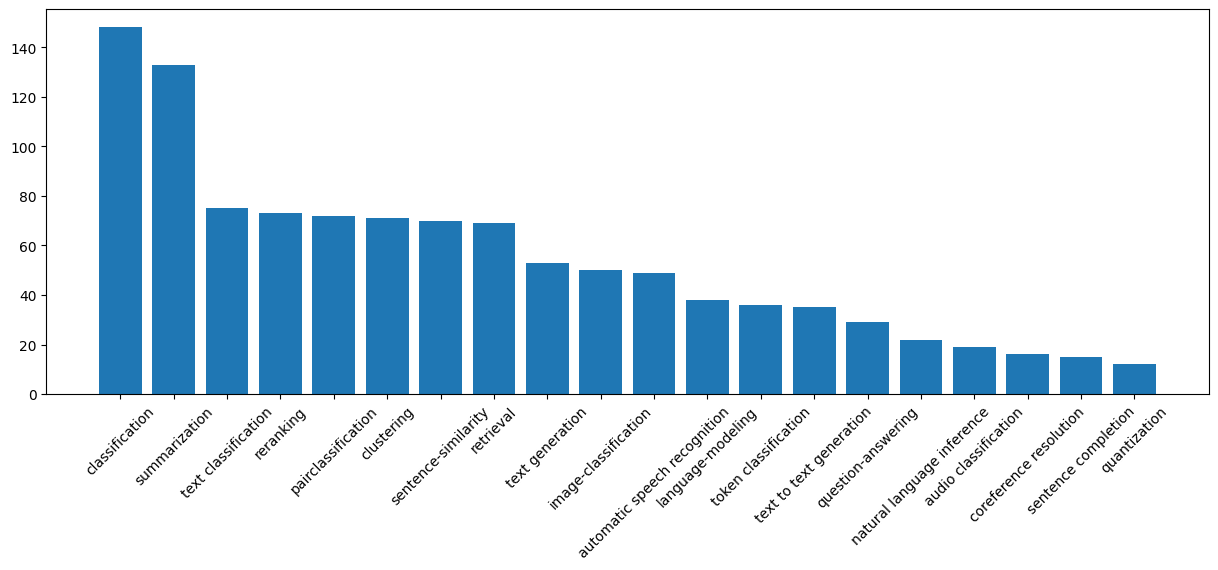

In [41]:
# plot histogram of top X task counts
top_x = 20
top_x_tasks = Counter(task_counts).most_common(top_x)

plt.figure(figsize=(15,5))
plt.bar([x[0] for x in top_x_tasks], [x[1] for x in top_x_tasks])
plt.xticks(rotation=45)
plt.show()

Now let's look at the tags

In [42]:
tags_label_data = []

for label in label_data:
    if label['tags']:
        tags_label_data.append(label['tags'])

In [43]:
for i in range(5):
    print(tags_label_data[i])

['keras', 'image-classification', 'onnx', 'region:us', 'license:mit', 'mobilenet']
['endpoints_compatible', 'distilbert', 'onnx', 'text-classification', 'region:us', 'autotrain_compatible', 'license:apache-2.0', 'transformers']
['ernie', 'onnx', 'transformers.js', 'region:us', 'fill-mask']
['onnx', 'zh', 'en', 'region:us', 'dataset:SWHL/text_det_test_dataset', 'license:apache-2.0']
['region:us', 'onnx']


we can see here that the tags are lists of user defined strings which can come in a abitraty order

In [44]:
tags = []

for tag_data in tags_label_data:
    tags.extend(list(set([t.lower().strip() for t in tag_data])))

In [45]:
unique_tags = set(tags)
print(f"Found {len(unique_tags)} unique tags")
unique_tags

Found 12493 unique tags


{'base_model:ericpeter/distilbert-base-uncased-finetuned-squad',
 'dataset:deepghs/anime_ch_ear',
 'stt',
 'dataset:ar4ikov/iemocap_audio_text_splitted',
 '4k',
 'dataset:damlab/uniprot',
 'clm',
 'dataset:amalq/autotrain-data-smm4h_large_roberta_clean',
 'base_model:bert-large-cased',
 'hun',
 'gptneo',
 'metallurgy',
 'dataset:wannita/pycoder-type',
 'dataset:article100v7_wikigold_split',
 'dataset:gfissore/arxiv-abstracts-2021',
 'github-issues',
 'kjv',
 'small',
 'dataset:hackaprompt/hackaprompt-dataset',
 'base_model:facebook/convnextv2-tiny-22k-224',
 'base_model:mediatek-research/breeze-7b-instruct-v1_0',
 'efficientnet',
 'environmental-claims',
 'language models',
 'arxiv:2311.09278',
 'arxiv:1810.09305',
 'vehicle-detection',
 'dataset:puffy310/autotrain-data-synth-cats-or-dogs',
 'beowolx/codeninja-1.0-openchat-7b',
 'dataset:1aurent/patchcamelyon',
 'arxiv:1904.02877',
 'dataset:codefuse-ai/evol-instruction-66k',
 'generated-from-trainer',
 'arxiv:2304.07666',
 'prl',
 'ba

In [46]:
tag_counts = {}

for t in tags:
    tag_counts[t] = tag_counts.get(t, 0) + 1

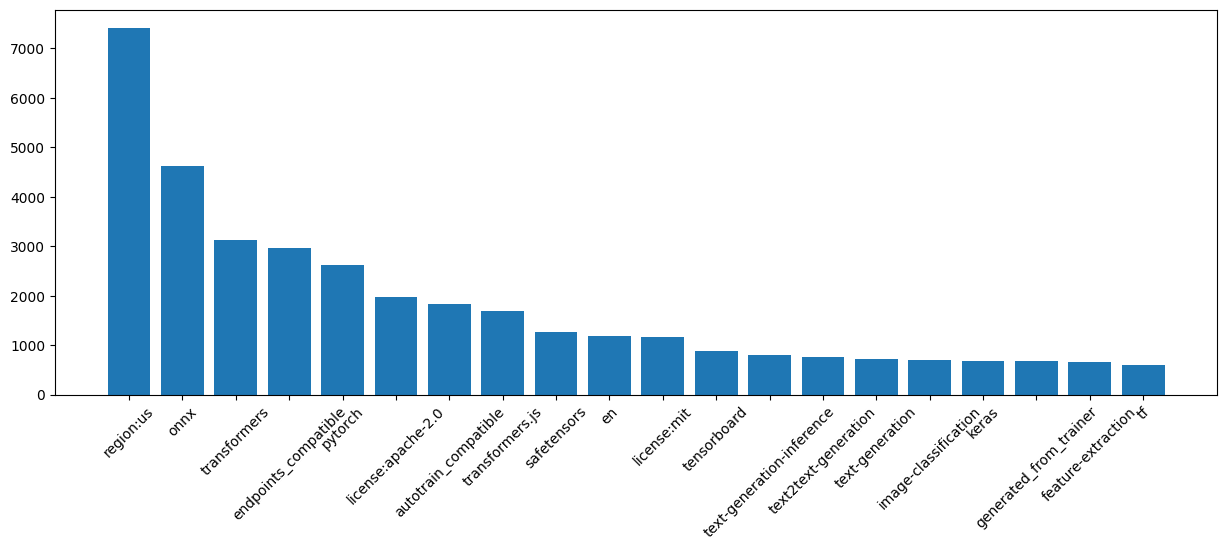

In [47]:
# plot histogram of top X task counts
top_x = 20
top_x_tags = Counter(tag_counts).most_common(top_x)

plt.figure(figsize=(15,5))
plt.bar([x[0] for x in top_x_tags], [x[1] for x in top_x_tags])
plt.xticks(rotation=45)
plt.show()

## Analyzing ONNX Attribute Types
We want to know which types of attributes e.g. INT, FLOAT etc. that are used in the networks to be able to convert them later.

In [48]:
import ast

att_type_count = {}

for i, graph_path in tqdm(enumerate(graph_paths), total=len(graph_paths)):
    NN = Network()
    NN.load(pathlib.Path(graph_path))

    nodes = NN.graph.nodes(data=True)

    for node, attrs in nodes:
        for att, (att_type, val) in attrs['features']['attributes'].items():
            # Count the number of attribute types
            att_type_count[att_type] = attrs.get(att_type, 0) + 1

100%|██████████| 7628/7628 [02:02<00:00, 62.39it/s] 


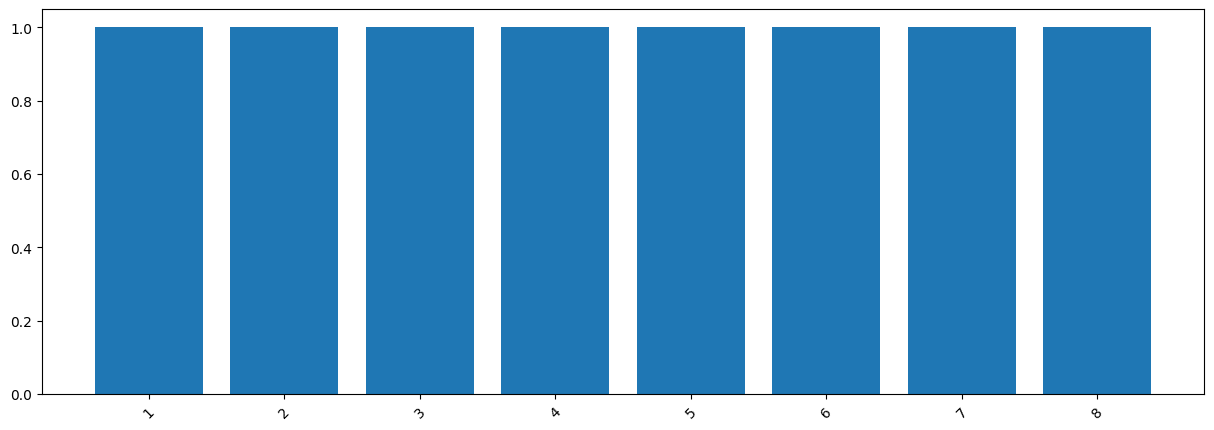

In [49]:
# Plot histogram of attribute types
plt.figure(figsize=(15,5))
plt.bar(*zip(*sorted(att_type_count.items())))
plt.xticks(rotation=45)
plt.show()

## Networks with TFLM Supported Operators
Now, let's look at how many of the networks that consist only of operators supported by TensorFlow Lite Micro

In [50]:
# Supported tensorflow operators
with open(os.path.join("tflm.json"), "r") as f:
    supported_ops = set(json.loads(f.read())['operators'])

supported_ops

{'Abs',
 'Add',
 'AddN',
 'ArgMax',
 'ArgMin',
 'AssignVariable',
 'AveragePool2D',
 'BatchMatMul',
 'BatchToSpaceNd',
 'BroadcastArgs',
 'BroadcastTo',
 'CallOnce',
 'Cast',
 'Ceil',
 'CircularBuffer',
 'Concatenation',
 'Conv2D',
 'Cos',
 'CumSum',
 'Delay',
 'DepthToSpace',
 'DepthwiseConv2D',
 'Dequantize',
 'DetectionPostprocess',
 'Div',
 'Elu',
 'EmbeddingLookup',
 'Energy',
 'Equal',
 'EthosU',
 'Exp',
 'ExpandDims',
 'FftAutoScale',
 'Fill',
 'FilterBank',
 'FilterBankLog',
 'FilterBankSpectralSubtraction',
 'FilterBankSquareRoot',
 'Floor',
 'FloorDiv',
 'FloorMod',
 'Framer',
 'FullyConnected',
 'Gather',
 'GatherNd',
 'Greater',
 'GreaterEqual',
 'HardSwish',
 'If',
 'Irfft',
 'L2Normalization',
 'L2Pool2D',
 'LeakyRelu',
 'Less',
 'LessEqual',
 'Log',
 'LogSoftmax',
 'LogicalAnd',
 'LogicalNot',
 'LogicalOr',
 'Logistic',
 'MaxPool2D',
 'Maximum',
 'Mean',
 'Minimum',
 'MirrorPad',
 'Mul',
 'Neg',
 'NotEqual',
 'OverlapAdd',
 'PCAN',
 'Pack',
 'Pad',
 'PadV2',
 'Prelu',
 '

In [51]:
# Find all networks consisting of only supported operators
supported_ops_graph_idxs = []

for i, graph_path in tqdm(enumerate(graph_paths), total=len(graph_paths)):
    NN = Network()
    NN.load(pathlib.Path(graph_path))
    if all([op in supported_ops for op in set(get_graph_operator_types(NN.graph))]):
        supported_ops_graph_idxs.append(i)

  0%|          | 0/7628 [00:00<?, ?it/s]

100%|██████████| 7628/7628 [02:01<00:00, 62.80it/s] 


In [52]:
print(f"Found {len(supported_ops_graph_idxs)} supported ops graphs out of {len(graph_paths)}")

Found 49 supported ops graphs out of 7628


We'll look at these graphs' nodes

In [53]:
for i in supported_ops_graph_idxs:
    NN = Network()
    NN.load(pathlib.Path(graph_paths[i]))
    print(NN.graph.nodes(data=True))

[('0', {'operator': {'op_type': 'LogSoftmax', 'domain': ''}, 'attributes': {'axis': {'value': -1, 'doc_string': '', 'attr_type': 2}}, 'features': {'operator': {'op_type': 'LogSoftmax', 'domain': ''}, 'attributes': {'axis': (2, '-1')}}})]
[('0', {'operator': {'op_type': 'ArgMax', 'domain': ''}, 'attributes': {'keepdims': {'value': 1, 'doc_string': '', 'attr_type': 2}, 'select_last_index': {'value': 1, 'doc_string': '', 'attr_type': 2}}, 'features': {'operator': {'op_type': 'ArgMax', 'domain': ''}, 'attributes': {'axis': (2, '0'), 'keepdims': (2, '1'), 'select_last_index': (2, '1')}}})]
[('0', {'operator': {'op_type': 'Tanh', 'domain': ''}, 'attributes': {}, 'features': {'operator': {'op_type': 'Tanh', 'domain': ''}, 'attributes': {}}})]
[('0', {'operator': {'op_type': 'Cast', 'domain': ''}, 'attributes': {'to': {'value': 6, 'doc_string': '', 'attr_type': 2}}, 'features': {'operator': {'op_type': 'Cast', 'domain': ''}, 'attributes': {'saturate': (2, '1'), 'to': (2, '6')}}}), ('1', {'oper

Let's see the label data on these graphs

In [54]:
supported_graphs_label_data = []

for i in supported_ops_graph_idxs:
    with open(label_paths[i], "r") as f:
        supported_graphs_label_data.append(json.loads(f.read()))

In [55]:
for l in supported_graphs_label_data:
    print(l)

{'model_sources': ['HuggingFace'], 'downloads': [0], 'likes': [0], 'tags': ['region:us', 'onnx'], 'evaluations': [], 'hash': 'a7e1a83323760d7aca87c294ab592084'}
{'model_sources': ['HuggingFace'], 'downloads': [0], 'likes': [0], 'tags': ['region:us', 'onnx'], 'evaluations': [], 'hash': 'c9f67fc675708725f51be3b3e13634d9'}
{'model_sources': ['HuggingFace'], 'downloads': [0], 'likes': [0], 'tags': ['region:us', 'onnx'], 'evaluations': [], 'hash': '219205651e61cd85fa1dab1e2661a930'}
{'model_sources': ['HuggingFace'], 'downloads': [1, 2, 3, 12, 17], 'likes': [0, 1, 2], 'tags': ['keras', 'region:us'], 'evaluations': [], 'hash': '8817359646651f2585162e52a057215b'}
{'model_sources': ['HuggingFace'], 'downloads': [0], 'likes': [0], 'tags': ['region:us', 'onnx'], 'evaluations': [], 'hash': '7e29bb0444ad42539818489bffb1b710'}
{'model_sources': ['HuggingFace'], 'downloads': [0], 'likes': [0], 'tags': ['region:us', 'onnx'], 'evaluations': [], 'hash': 'a11a53b54c7f1f28ec2e9c0949e48eed'}
{'model_sourc

So 50 out of over 7K networks is not a lot. Let's see if this is because some of the operator names in the Younger dataset <br> 
are a little different than the naming in the TFLM code definition.

In [56]:
threshold = 0.9

# Find all networks with a certain threshold of supported operators
threshold_ops_graph_idxs = []

for i, graph_path in tqdm(enumerate(graph_paths), total=len(graph_paths)):
    NN = Network()
    NN.load(pathlib.Path(graph_path))
    NN_ops = set(get_graph_operator_types(NN.graph))
    supported_ops_count = sum([op in supported_ops for op in NN_ops])
    if supported_ops_count / len(NN_ops) >= threshold:
        threshold_ops_graph_idxs.append(i)

100%|██████████| 7628/7628 [02:02<00:00, 62.10it/s] 


In [57]:
print(f"Found {len(threshold_ops_graph_idxs)} threshold ops graphs out of {len(graph_paths)}")

Found 49 threshold ops graphs out of 7628


Okay, let's take the set of TFLM operators and the set of all network operators in Younger and compare them.

In [58]:
NN_ops_set = set(operator_types)

NN_ops_set.issuperset(supported_ops)

False

In [59]:
ops_diff = supported_ops - NN_ops_set
print(f"Found {len(ops_diff)} unsupported operators")
print(ops_diff)

Found 72 unsupported operators
{'EthosU', 'LessEqual', 'AveragePool2D', 'BatchToSpaceNd', 'AssignVariable', 'Square', 'Mean', 'LogicalNot', 'Logistic', 'L2Normalization', 'Relu6', 'CircularBuffer', 'Minimum', 'Prelu', 'LogicalOr', 'DetectionPostprocess', 'Framer', 'ReadVariable', 'Svdf', 'FullyConnected', 'While', 'FilterBank', 'DepthwiseConv2D', 'MaxPool2D', 'Quantize', 'FloorDiv', 'NotEqual', 'SplitV', 'StridedSlice', 'Rsqrt', 'EmbeddingLookup', 'Unpack', 'MirrorPad', 'Window', 'ResizeBilinear', 'BatchMatMul', 'Pack', 'TransposeConv', 'ExpandDims', 'SquaredDifference', 'OverlapAdd', 'FftAutoScale', 'FilterBankSpectralSubtraction', 'GreaterEqual', 'Concatenation', 'SpaceToBatchNd', 'Irfft', 'VarHandle', 'PCAN', 'Energy', 'AddN', 'UnidirectionalSequenceLSTM', 'BroadcastTo', 'BroadcastArgs', 'FilterBankSquareRoot', 'FilterBankLog', 'CallOnce', 'GatherNd', 'L2Pool2D', 'Fill', 'FloorMod', 'ZerosLike', 'Stacker', 'Dequantize', 'ResizeNearestNeighbor', 'Conv2D', 'Maximum', 'SelectV2', 'Rfft

Okay, so we see some operators here like `Conv2D` which should clearly be part of the operators in the Younger Dataset. <br>
Most likely there is a mismatch in the operator naming.

To get around this, we will create a converter that can take the networkx graphs that are saved with ONNX operator names and change the operators names <br>
to the TensorFlow naming convention.

In [60]:

NN = Network()
NN.load(pathlib.Path(graph_paths[0]))

onnx_model = networkx_to_onnx(NN.graph, input_shape=(1, 128, 128, 3), output_shape=(1,2))
shaped_onnx_model = infer_shapes(onnx_model)

In [61]:
shaped_onnx_model.graph.node

[input: "data"
output: "node_0"
name: "node_0"
op_type: "Transpose"
attribute {
  name: "perm"
  ints: 0
  ints: 3
  ints: 1
  ints: 2
  type: INTS
}
, input: "node_0"
input: "Conv_weights_1"
output: "node_1"
name: "node_1"
op_type: "Conv"
attribute {
  name: "dilations"
  ints: 1
  ints: 1
  type: INTS
}
attribute {
  name: "group"
  i: 1
  type: INT
}
attribute {
  name: "kernel_shape"
  ints: 3
  ints: 3
  type: INTS
}
attribute {
  name: "strides"
  ints: 1
  ints: 1
  type: INTS
}
, input: "node_1"
output: "node_2"
name: "node_2"
op_type: "Relu"
, input: "node_2"
output: "node_3"
name: "node_3"
op_type: "MaxPool"
attribute {
  name: "ceil_mode"
  i: 0
  type: INT
}
attribute {
  name: "kernel_shape"
  ints: 2
  ints: 2
  type: INTS
}
attribute {
  name: "storage_order"
  i: 0
  type: INT
}
attribute {
  name: "strides"
  ints: 2
  ints: 2
  type: INTS
}
, input: "node_3"
input: "Conv_weights_4"
output: "node_4"
name: "node_4"
op_type: "Conv"
attribute {
  name: "dilations"
  ints:

In [62]:
# Load tensorflow tensor image
image_path = os.path.join("..", "output", "tf_images", "corgi_128_tensor.npy")

# Load tensor
def load_npy_tensor(file_path):
    # Load the .npy file
    np_tensor = np.load(file_path)
    
    # Convert the numpy array to a TensorFlow tensor
    tf_tensor = tf.convert_to_tensor(np_tensor, dtype=tf.float32)
    return tf_tensor

img = load_npy_tensor(image_path)

In [63]:
img.shape

TensorShape([1, 128, 128, 3])

In [64]:
from onnx.reference import ReferenceEvaluator
oinf = ReferenceEvaluator(shaped_onnx_model, verbose=3)
oinf.run(None, {"data": img})

 +C Conv_weights_1: float32:(3, 3, 3, 3) in [0.005799548234790564, 0.9873749017715454]
 +C Conv_weights_4: float32:(3, 3, 3, 3) in [0.013121675699949265, 0.9898065328598022]
 +C Conv_weights_7: float32:(3, 3, 3, 3) in [0.017238562926650047, 0.9944615960121155]
 +C Reshape_shape_11: int64:(2,) in [-1, 1]
 +C Matmul_Y_12: float32:(588, 2) in [0.0002200048038503155, 0.999717652797699]
 +C Add_Y_13: float32:(1, 2) in [0.5989547371864319, 0.811248779296875]
 +C Matmul_Y_15: float32:(2, 2) in [0.11177827417850494, 0.6971498727798462]
 +C Add_Y_16: float32:(1, 2) in [0.416871577501297, 0.6541643142700195]
 +I data: tf.Tensor(
[[[[0.34509805 0.30980393 0.27450982]
   [0.34901962 0.31764707 0.28627452]
   [0.34509805 0.31764707 0.28627452]
   ...
   [0.16078432 0.15686275 0.15686275]
   [0.16470589 0.16862746 0.16078432]
   [0.1764706  0.1764706  0.16862746]]

  [[0.3529412  0.31764707 0.28627452]
   [0.34901962 0.3254902  0.29411766]
   [0.33333334 0.3137255  0.28235295]
   ...
   [0.16078432 

[array([[1., 0.]], dtype=float32)]

In [65]:
# Save the onnx model
onnx_path = os.path.join(OUTPUT_DIR, "onnx_model.onnx")
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [66]:
onnx.checker.check_model(onnx_path)

Now let's try and convert the onnx model to tensorflow format.

In [67]:
! onnx2tf -i ../output/onnx_model.onnx -o ../output/tf_onnx_model -b 1 -kat data


Model optimizing started ============================================================
Traceback (most recent call last):
  File "/home/wdm/YoungerNNs/.venv/lib/python3.12/site-packages/onnx2tf/onnx2tf.py", line 645, in convert
    result = subprocess.check_output(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 466, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 571, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['onnxsim', '../output/onnx_model.onnx', '../output/onnx_model.onnx']' returned non-zero exit status 1.


Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model co

Now, we load the tensorflow model and look at the operator names.

In [68]:
# Load tensorflow model from output/tf_onnx_model
tf_model = tf.saved_model.load("../output/tf_onnx_model")

Let's try the model on an input. This particular model takes an image.

In [69]:
tf_model.serving_default(img)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

Now let's look at the operators in the tensorflow graph

In [83]:
concrete_func = tf_model.signatures['inference']
tf_graph =concrete_func.graph.as_graph_def()

KeyError: 'inference'

In [100]:
function_library = tf_graph.library
function_defs = [f for f in function_library.function]

In [104]:
for n in function_defs[0].node_def:
    print(n.op)

Const
Transpose
Const
Transpose
Conv2D
Relu
MaxPool
Conv2D
Relu
MaxPool
Conv2D
Relu
MaxPool
Const
Reshape
MatMul
AddV2
Relu
MatMul
AddV2
Softmax
Identity
